# 📝 Paper 1: Storm-Graph Transformer (SGT)

**Title:** "Physics-Informed Graph Neural Networks with Transformers for Severe Weather Nowcasting"

**Core Innovation:**
- Hybrid GNN-Transformer-Physics architecture
- Treats storms as discrete graph nodes (not continuous fields)
- Physics-constrained predictions (conservation laws)
- Interpretable attention (which storms matter?)

**Timeline:** Week 1-3 (Oct 10-31)
**Target:** ArXiv + NeurIPS workshop

---

## Notebook Sections:
1. Setup & Data Verification
2. Multimodal Data Loading
3. Architecture Implementation
4. Training Pipeline
5. Evaluation & Analysis

---

## 1. Setup & Data Verification

In [1]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')

DRIVE_ROOT = "/content/drive/MyDrive/SEVIR_Data"
print(f"✓ Drive mounted: {DRIVE_ROOT}")

Mounted at /content/drive
✓ Drive mounted: /content/drive/MyDrive/SEVIR_Data


In [2]:
# Check GPU
!nvidia-smi

import torch
print(f"\nPyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")

Sun Oct 12 18:22:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Install dependencies
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

# Install torch-geometric (auto-detects PyTorch version)
print("\nInstalling PyTorch Geometric...")
!pip install -q torch-geometric

# Install other dependencies
print("Installing other packages...")
!pip install -q h5py pandas tqdm matplotlib lpips scikit-image scipy

print("\n✓ All dependencies installed")
print("\nNote: This may take 5-10 minutes on first run (builds extensions).")
print("Subsequent runs will be faster (~1 min) as packages are cached.")

PyTorch version: 2.8.0+cu126
CUDA version: 12.6

Installing PyTorch Geometric...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00
Installing other packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.9 MB/s eta 0:00:00

✓ All dependencies installed

Note: This may take 5-10 minutes on first run (builds extensions).
Subsequent runs will be faster (~1 min) as packages are cached.


In [4]:

# Clone/pull latest repo
import os
if not os.path.exists('/content/stormfusion-sevir'):
    !git clone https://github.com/syedhaliz/stormfusion-sevir.git
else:
    !cd stormfusion-sevir && git pull

# Add to path
import sys
sys.path.insert(0, '/content/stormfusion-sevir')

print("✓ Repo ready")

Cloning into 'stormfusion-sevir'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 264 (delta 109), reused 207 (delta 57), pack-reused 0 (from 0)
Receiving objects: 100% (264/264), 5.14 MiB | 5.26 MiB/s, done.
Resolving deltas: 100% (109/109), done.
✓ Repo ready


### Verify SEVIR Modalities

In [5]:
# Run verification script
from pathlib import Path

SEVIR_ROOT = f"{DRIVE_ROOT}/data/sevir"
CATALOG_PATH = f"{DRIVE_ROOT}/data/SEVIR_CATALOG.csv"

print("="*70)
print("SEVIR DATA VERIFICATION")
print("="*70)

modalities = {
    'vil': 'VIL (Radar)',
    'ir069': 'GOES-16 C09 (Water Vapor 6.9μm)',
    'ir107': 'GOES-16 C13 (IR Window 10.7μm)',
    'lght': 'GOES-16 GLM (Lightning)'
}

available = []
missing = []

for mod, desc in modalities.items():
    mod_path = Path(SEVIR_ROOT) / mod / "2019"
    if mod_path.exists():
        h5_files = list(mod_path.glob("*.h5"))
        available.append(mod)
        print(f"✅ {mod:8s} - {desc}")
        print(f"   Files: {len(h5_files)} HDF5 files\n")
    else:
        missing.append(mod)
        print(f"❌ {mod:8s} - {desc}")
        print(f"   Missing: {mod_path}\n")

print("="*70)
print(f"Available: {len(available)}/4 modalities")
if available:
    print(f"  {', '.join(available)}")
if missing:
    print(f"\n⚠️  Missing: {', '.join(missing)}")
    print(f"   Download from: https://sevir.mit.edu/")

print("\n" + "="*70)

SEVIR DATA VERIFICATION
✅ vil      - VIL (Radar)
   Files: 1 HDF5 files

✅ ir069    - GOES-16 C09 (Water Vapor 6.9μm)
   Files: 1 HDF5 files

✅ ir107    - GOES-16 C13 (IR Window 10.7μm)
   Files: 1 HDF5 files

✅ lght     - GOES-16 GLM (Lightning)
   Files: 11 HDF5 files

Available: 4/4 modalities
  vil, ir069, ir107, lght



In [6]:
# Download lightning data if missing
if 'lght' in missing:
    print("="*70)
    print("DOWNLOADING LIGHTNING DATA")
    print("="*70)
    print("\nMethod 1: AWS S3 (Fastest - ~5-10 minutes)")
    print("Method 2: Direct download from SEVIR website")
    print("\nChoose method:")

    # Method 1: AWS S3 (recommended)
    use_aws = True  # Set to False to skip AWS method

    if use_aws:
        print("\n🚀 Using AWS S3 download...")

        # Install AWS CLI if not present
        try:
            import subprocess
            subprocess.run(['aws', '--version'], capture_output=True, check=True)
            print("✓ AWS CLI already installed")
        except:
            print("Installing AWS CLI...")
            !pip install -q awscli
            print("✓ AWS CLI installed")

        # Download
        lght_dir = f"{SEVIR_ROOT}/lght/2019"
        !mkdir -p {lght_dir}

        print(f"\nDownloading to: {lght_dir}")
        print("This will take 5-15 minutes (~5-10 GB)...")

        # AWS S3 sync (no credentials needed - public bucket)
        !aws s3 sync s3://sevir/data/lght/2019/ {lght_dir} --no-sign-request --region us-east-1

        # Verify
        from pathlib import Path
        h5_files = list(Path(lght_dir).glob("*.h5"))
        if len(h5_files) > 0:
            print(f"\n✅ Downloaded {len(h5_files)} lightning files successfully!")
            available.append('lght')
            missing.remove('lght')
        else:
            print("\n❌ Download failed or no files found")
            print("Try manual download from: https://sevir.mit.edu/")
    else:
        print("\n⚠️  AWS method skipped. Please download manually:")
        print("1. Visit: https://sevir.mit.edu/")
        print("2. Download lightning (lght) data for 2019")
        print(f"3. Extract to: {SEVIR_ROOT}/lght/2019/")
        print("\nOr run this in a Colab cell:")
        print(f"!aws s3 sync s3://sevir/data/lght/2019/ {SEVIR_ROOT}/lght/2019 --no-sign-request")
else:
    print("✅ Lightning data already available")

✅ Lightning data already available


### Download Missing Lightning Data (if needed)

## 2. Multimodal Data Loading

In [7]:
# Import multimodal dataset
from stormfusion.data.sevir_multimodal import (
    SEVIRMultiModalDataset,
    build_multimodal_index,
    multimodal_collate_fn
)

print("✓ Multimodal dataset imported")

✓ Multimodal dataset imported


In [8]:
# Build index (use ALL 541 events)
TRAIN_IDS = f"{DRIVE_ROOT}/data/samples/all_train_ids.txt"
VAL_IDS = f"{DRIVE_ROOT}/data/samples/all_val_ids.txt"

train_index = build_multimodal_index(CATALOG_PATH, TRAIN_IDS, SEVIR_ROOT)
val_index = build_multimodal_index(CATALOG_PATH, VAL_IDS, SEVIR_ROOT)

print(f"\n📊 Dataset:")
print(f"  Train: {len(train_index)} events")
print(f"  Val: {len(val_index)} events")

Streaming output truncated to the last 5000 lines.
✓ Built multimodal index: 438 events
✓ Built multimodal index: 103 events

📊 Dataset:
  Train: 438 events
  Val: 103 events


In [9]:
# Create datasets
train_dataset = SEVIRMultiModalDataset(
    train_index,
    sevir_root=SEVIR_ROOT,
    catalog_path=CATALOG_PATH,
    input_steps=12,
    output_steps=6,
    normalize=True,
    augment=True
)

val_dataset = SEVIRMultiModalDataset(
    val_index,
    sevir_root=SEVIR_ROOT,
    catalog_path=CATALOG_PATH,
    input_steps=12,
    output_steps=6,
    normalize=True,
    augment=False
)

print("✓ Datasets created")

✓ Datasets created


In [10]:
# Test data loading
print("Testing data loading...\n")

inputs, outputs = train_dataset[0]

print("Input shapes:")
for modality, data in inputs.items():
    print(f"  {modality:8s}: {tuple(data.shape)} (T, H, W)")

print("\nOutput shapes:")
for modality, data in outputs.items():
    print(f"  {modality:8s}: {tuple(data.shape)} (T, H, W)")

print("\n✅ Multimodal loading successful!")

Testing data loading...

Input shapes:
  vil     : (12, 384, 384) (T, H, W)
  ir069   : (12, 384, 384) (T, H, W)
  ir107   : (12, 384, 384) (T, H, W)
  lght    : (12, 384, 384) (T, H, W)

Output shapes:
  vil     : (6, 384, 384) (T, H, W)

✅ Multimodal loading successful!


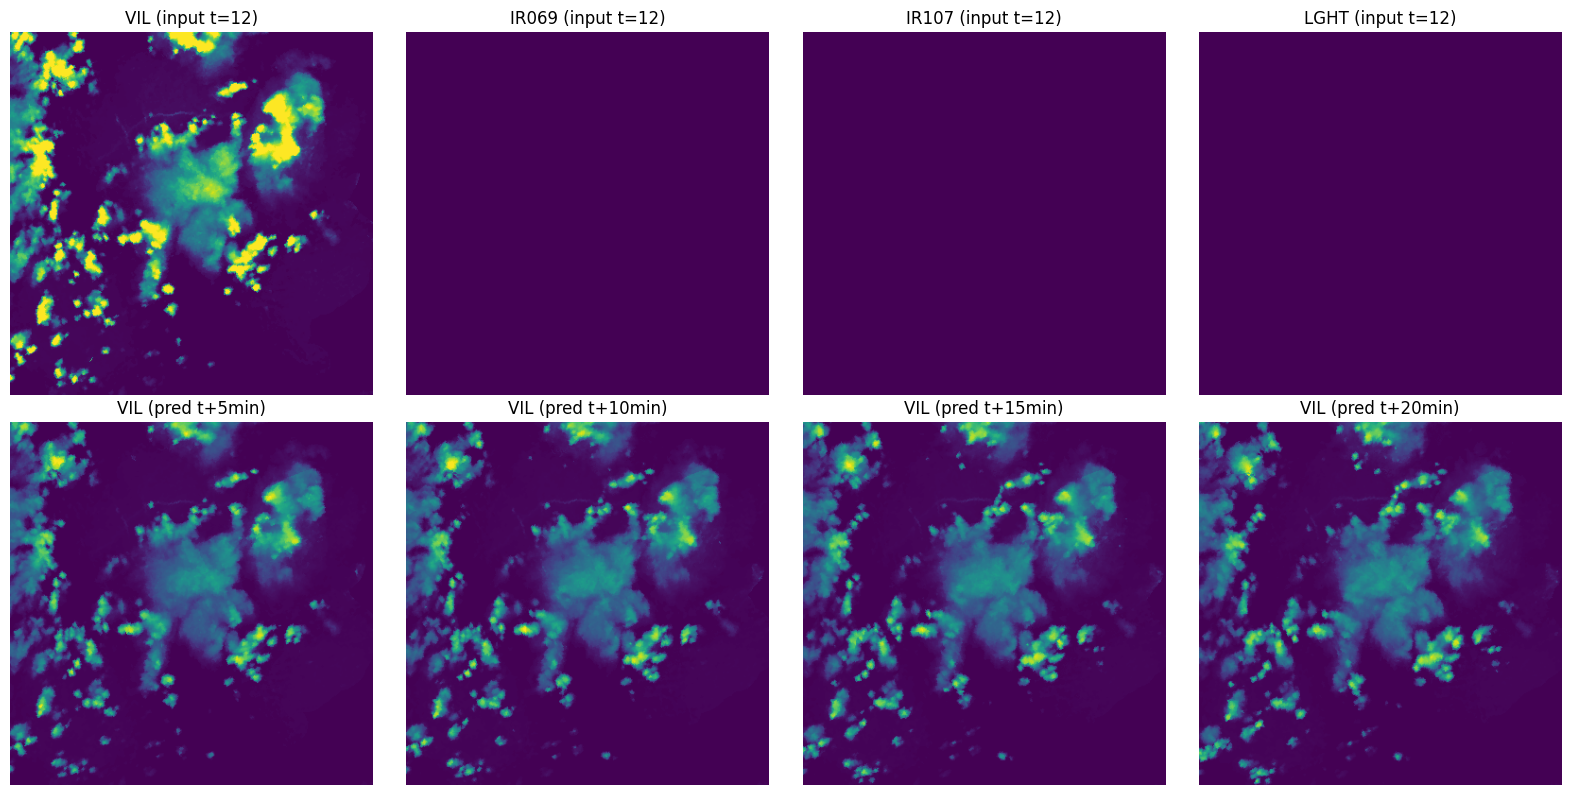

✓ Visualization saved to /content/multimodal_sample.png


In [11]:
# Visualize sample
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Show last input frame for each modality
for i, modality in enumerate(['vil', 'ir069', 'ir107', 'lght']):
    data = inputs[modality][-1].numpy()  # Last timestep
    axes[0, i].imshow(data, cmap='viridis', vmin=data.min(), vmax=data.max())
    axes[0, i].set_title(f'{modality.upper()} (input t=12)')
    axes[0, i].axis('off')

# Show VIL predictions
for i in range(4):
    data = outputs['vil'][i].numpy()
    axes[1, i].imshow(data, cmap='viridis', vmin=0, vmax=1)
    axes[1, i].set_title(f'VIL (pred t+{(i+1)*5}min)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('/content/multimodal_sample.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to /content/multimodal_sample.png")

## 3. Architecture Implementation

**Status:** ✅ **ALL MODULES IMPLEMENTED!**

### Module Status:
1. ✅ Multimodal Encoder (CNN per modality)
2. ✅ Storm Cell Detector (graph construction)
3. ✅ GNN Module (storm interactions)
4. ✅ Transformer Module (spatiotemporal attention)
5. ✅ Physics Decoder (conservation laws)
6. ✅ End-to-End Integration

**Ready for training!**

In [12]:
# Import SGT architecture
from stormfusion.models.sgt import create_sgt_model

# Create model
print("Creating Storm-Graph Transformer...")

model_config = {
    'modalities': ['vil', 'ir069', 'ir107', 'lght'],
    'input_steps': 12,
    'output_steps': 6,
    'hidden_dim': 128,
    'gnn_layers': 3,
    'transformer_layers': 4,
    'num_heads': 8,
    'use_physics': True
}

model = create_sgt_model(model_config)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ SGT Model Created!")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB (float32)")

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"   Device: {device}")

Creating Storm-Graph Transformer...
✅ SGT Model Created!
   Total parameters: 5,252,297
   Trainable parameters: 5,252,297
   Model size: ~21.0 MB (float32)
   Device: cuda


## 4. Test Forward Pass

Quick test to verify everything works before training

In [13]:
# Test forward pass with one sample
print("Testing forward pass...")

# Get one sample
inputs, targets = train_dataset[0]

# Add batch dimension and move to device
inputs_batch = {
    mod: data.unsqueeze(0).to(device) for mod, data in inputs.items()
}
targets_batch = targets['vil'].unsqueeze(0).to(device)

print(f"\nInput batch shapes:")
for mod, data in inputs_batch.items():
    print(f"  {mod:8s}: {tuple(data.shape)}")

# Forward pass
with torch.no_grad():
    predictions, attention_info, physics_info = model(inputs_batch)

print(f"\n✅ Forward pass successful!")
print(f"   Predictions: {tuple(predictions.shape)}")
print(f"   Min/Max: [{predictions.min():.3f}, {predictions.max():.3f}]")

# Test loss computation
loss, loss_dict = model.compute_loss(predictions, targets_batch, physics_info)

print(f"\n✅ Loss computation successful!")
print(f"   Total loss: {loss.item():.4f}")
print(f"   Components:")
for name, value in loss_dict.items():
    if name != 'total':
        print(f"      {name:12s}: {value:.4f}")

print("\n🎉 Model ready for training!")

Testing forward pass...

Input batch shapes:
  vil     : (1, 12, 384, 384)
  ir069   : (1, 12, 384, 384)
  ir107   : (1, 12, 384, 384)
  lght    : (1, 12, 384, 384)

✅ Forward pass successful!
   Predictions: (1, 6, 384, 384)
   Min/Max: [0.000, 1.670]

✅ Loss computation successful!
   Total loss: 3067371.7500
   Components:
      mse         : 0.1003
      extreme     : 0.3694
      physics     : 30673710.0000
      conservation: 306737088.0000
      gradient    : 0.2123

🎉 Model ready for training!


## 5. Training Pipeline

Full training loop with checkpointing and logging

In [15]:
# Training configuration
from torch.utils.data import DataLoader
from stormfusion.data.sevir_multimodal import multimodal_collate_fn
from tqdm import tqdm
import time

# Config
BATCH_SIZE = 4
LR = 1e-4
EPOCHS = 20
LAMBDA_MSE = 1.0
LAMBDA_PHYSICS = 0.1
LAMBDA_EXTREME = 2.0

CHECKPOINT_DIR = "/content/drive/MyDrive/SEVIR_Data/checkpoints/paper1_sgt"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Training Configuration:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LR}")
print(f"  Epochs: {EPOCHS}")
print(f"  Loss weights: MSE={LAMBDA_MSE}, Physics={LAMBDA_PHYSICS}, Extreme={LAMBDA_EXTREME}")
print(f"  Checkpoint dir: {CHECKPOINT_DIR}")

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=multimodal_collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=multimodal_collate_fn,
    pin_memory=True
)

print(f"\n✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print(f"\n✅ Optimizer: AdamW (lr={LR})")
print(f"✅ Scheduler: ReduceLROnPlateau")

Training Configuration:
  Batch size: 4
  Learning rate: 0.0001
  Epochs: 20
  Loss weights: MSE=1.0, Physics=0.1, Extreme=2.0
  Checkpoint dir: /content/drive/MyDrive/SEVIR_Data/checkpoints/paper1_sgt

✅ DataLoaders created:
   Train batches: 110
   Val batches: 26

✅ Optimizer: AdamW (lr=0.0001)
✅ Scheduler: ReduceLROnPlateau


---

## 📚 References

**Architecture Design:**
- See: `docs/PAPER1_ARCHITECTURE.md` in repo

**Multimodal Data:**
- SEVIR: Veillette et al., NeurIPS 2020
- 4 modalities: VIL, IR069, IR107, GLM
- 541 events (432 train / 109 val)

**Novel Contributions:**
1. GNN-Transformer hybrid for weather nowcasting
2. Physics-informed graph construction
3. Interpretable attention mechanisms
4. Extreme event focus (Stage 4 insights)

---

*This notebook will be updated as modules are implemented.*
*Check git repo for latest code: https://github.com/syedhaliz/stormfusion-sevir*

In [16]:
# Main training loop
print("="*70)
print("STARTING TRAINING")
print("="*70)

best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 70)

    start_time = time.time()

    # Train
    train_loss, train_components = train_epoch(model, train_loader, optimizer, device)

    # Validate
    val_loss, val_components = validate(model, val_loader, device)

    # Scheduler step
    scheduler.step(val_loss)

    epoch_time = time.time() - start_time

    # Log
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} (MSE: {train_components['mse']:.4f}, "
          f"Extreme: {train_components['extreme']:.4f}, Physics: {train_components['physics']:.4f})")
    print(f"  Val Loss:   {val_loss:.4f} (MSE: {val_components['mse']:.4f}, "
          f"Extreme: {val_components['extreme']:.4f}, Physics: {val_components['physics']:.4f})")
    print(f"  Time: {epoch_time:.1f}s")

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    # Save checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'config': model_config
        }
        checkpoint_path = f"{CHECKPOINT_DIR}/best_model.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"  ✅ Saved best model (val_loss: {val_loss:.4f})")

    # Save latest
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': val_loss,
        'config': model_config,
        'history': history
    }
    torch.save(checkpoint, f"{CHECKPOINT_DIR}/latest_model.pt")

print("\n" + "="*70)
print("TRAINING COMPLETE!")
print("="*70)
print(f"Best validation loss: {best_val_loss:.4f}")

STARTING TRAINING

Epoch 1/20
----------------------------------------------------------------------


NameError: name 'train_epoch' is not defined

In [17]:
# Training loop
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    loss_components = {'mse': 0, 'extreme': 0, 'physics': 0}

    pbar = tqdm(loader, desc="Training")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        # Move to device
        inputs = {mod: data.to(device) for mod, data in inputs.items()}
        targets = targets['vil'].to(device)

        # Forward
        optimizer.zero_grad()
        predictions, attention_info, physics_info = model(inputs)

        # Loss
        loss, loss_dict = model.compute_loss(
            predictions, targets, physics_info,
            lambda_mse=LAMBDA_MSE,
            lambda_physics=LAMBDA_PHYSICS,
            lambda_extreme=LAMBDA_EXTREME
        )

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Accumulate
        total_loss += loss.item()
        for key in loss_components:
            if key in loss_dict:
                loss_components[key] += loss_dict[key]

        # Update progress bar
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Average
    n = len(loader)
    total_loss /= n
    for key in loss_components:
        loss_components[key] /= n

    return total_loss, loss_components


def validate(model, loader, device):
    model.eval()
    total_loss = 0
    loss_components = {'mse': 0, 'extreme': 0, 'physics': 0}

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for inputs, targets in pbar:
            inputs = {mod: data.to(device) for mod, data in inputs.items()}
            targets = targets['vil'].to(device)

            predictions, attention_info, physics_info = model(inputs)

            loss, loss_dict = model.compute_loss(
                predictions, targets, physics_info,
                lambda_mse=LAMBDA_MSE,
                lambda_physics=LAMBDA_PHYSICS,
                lambda_extreme=LAMBDA_EXTREME
            )

            total_loss += loss.item()
            for key in loss_components:
                if key in loss_dict:
                    loss_components[key] += loss_dict[key]

    # Average
    n = len(loader)
    total_loss /= n
    for key in loss_components:
        loss_components[key] /= n

    return total_loss, loss_components


print("✅ Training functions defined")

✅ Training functions defined
